# Data Sanity Checks


The notebook will be used to conduit a number of sanity check give by Sohan on the data generation

## The checks
Below are the following tests
1. checking that emission spectra converges to the true spectra when the number of photons increases [I think this was done already]
2. checking if spectral jitter beyond PDE is caused by the IRF lag, which we can do by making the IRF a fixed lag only over all spectral channel
3. checking if an individual spectra channel become exponential when the number of photons increases (without bias to begin with)
4. checking if 3 holds with bias, I have a feeling the way we are adding bias might be wrong since Alex pointed out that the bias takes the shape of emission spectra after MuFLE fit.

## Initalisation of Fluorophores that will be used

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../src/")
from Intensity_PDF import *
from Tissue_Fluorophore import Tissue_Fluorophore
from irf_function import IRF
from spectral_sensitivity import SpectralSensitivity
from random_intensity_distrbution import IntensityPDFGenerator
from probe_config import CHANNEL_RANGE, CHANNEL_WIDTH
from bias import Bias
import numpy as np
from typing import Tuple
from visualisation_utils import (
    save_data,
    save_peak_intensities,
    plot_peak_intensity_per_channel,
    data_and_irf_inspection,
    single_data_and_irf_inspection,
    get_max_and_average_peak_intensity_per_channel,
    get_peak_intensity_per_channel,
)
from scipy import signal
from scipy import interpolate as interp
import seaborn as sns

In [3]:
# sns.set_style("whitegrid")

Setting up the splines that will be used as the distributions 

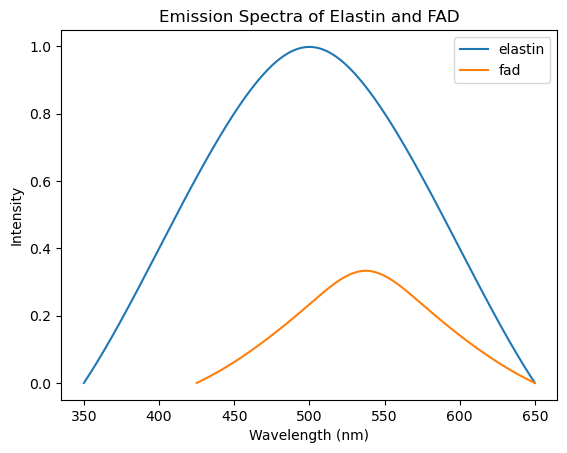

In [4]:
distribution_locations = "../data/endogenous-fluoro-emissions"
# loading elastin and fad splines (riboflavin is same emission as fad for now)
elastin_spline_info = np.load(f"{distribution_locations}/elastin_spline.npz")
elastin_bounds = Wavebounds(
    np.min(elastin_spline_info["x"]), np.max(elastin_spline_info["x"])
)
elastin_spline = interp.UnivariateSpline(
    elastin_spline_info["x"], elastin_spline_info["y"], s=elastin_spline_info["s"]
)

fad_spline_info = np.load(f"{distribution_locations}/fad_spline.npz")
fad_bounds = Wavebounds(np.min(fad_spline_info["x"]), np.max(fad_spline_info["x"]))
fad_spline = interp.UnivariateSpline(
    fad_spline_info["x"], fad_spline_info["y"], s=fad_spline_info["s"]
)

# plot the splines
elastin_x = np.linspace(*elastin_bounds, 1000)
elastin_y = elastin_spline(elastin_x)

fad_x = np.linspace(*fad_bounds, 1000)
fad_y = fad_spline(fad_x)

plt.figure()
sns.lineplot(x=elastin_x, y=elastin_y, label="elastin")
sns.lineplot(x=fad_x, y=fad_y, label="fad")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Emission Spectra of Elastin and FAD")
plt.legend()
plt.show()

Setting up the fluoros that we are going to use throughout the checks: elastin, flavin and riboflavin

In [5]:
# defining the IRF and spectral sensitivity
irf = IRF()
spectral_sensitivity = SpectralSensitivity(blue_pde_range=(0, 1), red_pde_range=(0, 1))

# defining the tissue fluorophores
elastin = Tissue_Fluorophore(
    elastin_spline,
    elastin_bounds,
    0,
    spectral_sensitivity.red_spad_sensitivity,
    spectral_sensitivity.red_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "Elastin",
)

fad = Tissue_Fluorophore(
    fad_spline,
    fad_bounds,
    0,
    spectral_sensitivity.blue_spad_sensitivity,
    spectral_sensitivity.blue_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "FAD",
)

riboflavin = Tissue_Fluorophore(
    fad_spline,
    fad_bounds,
    0,
    spectral_sensitivity.blue_spad_sensitivity,
    spectral_sensitivity.blue_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "Riboflavin",
)

In [6]:
wavelength_spectra = np.arange(CHANNEL_RANGE[0], CHANNEL_RANGE[1], CHANNEL_WIDTH)[:-1]
wavelength_spectra.shape

(1375,)

# Convergence to emission spectra
Here will test check 1, we should see as we increase the number of photons, then the emission converges to the distribution used to for the generation process

### Straight Line

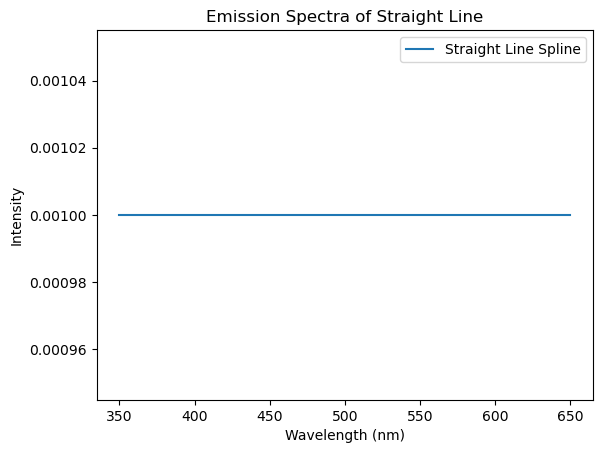

In [7]:
straight_line_bounds = (350, 650)
straight_line_x = np.linspace(*straight_line_bounds, 1000)
straight_line_y = np.ones_like(straight_line_x)
straight_line_y = straight_line_y / np.sum(straight_line_y)

straight_line_spline = interp.interp1d(straight_line_x, straight_line_y)
straight_line_spline_test_y = straight_line_spline(straight_line_x)

plt.figure()
# sns.lineplot(x=straight_line_x, y=straight_line_y, label="Straight Line")
sns.lineplot(
    x=straight_line_x, y=straight_line_spline_test_y, label="Straight Line Spline"
)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Emission Spectra of Straight Line")
plt.legend()
plt.show()

### Desired spectra
We will be using elastin and afterwards we will use a randomly generated spectra

Strictness: 0.005107494436477501
Start Wavelength: 897.4774561571038
End Wavelength: 1000
Number of knots : (7,)
Number of parameters: (10,)


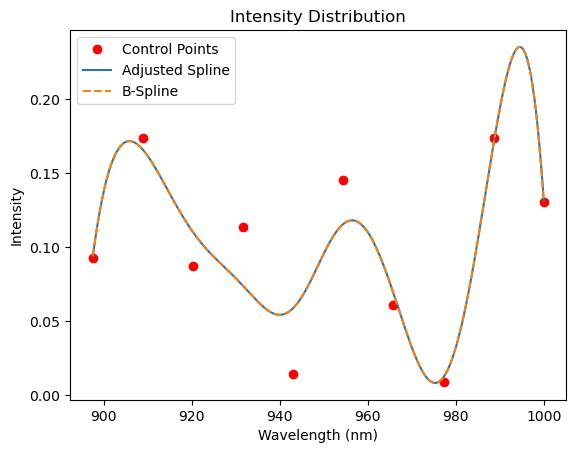

In [8]:
# lets generate our random distribution
intensity_distribution_generator = IntensityPDFGenerator()

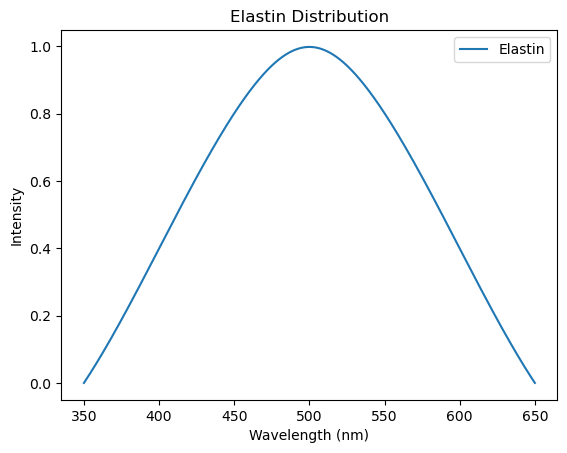

In [9]:
# lets plot the elastin distribution
plt.figure()
sns.lineplot(x=elastin_x, y=elastin_y, label="Elastin")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Elastin Distribution")
plt.legend()
plt.show()

In [10]:
# straight line fluoro
straight_line_fluoro = Tissue_Fluorophore(
    straight_line_spline,
    straight_line_bounds,
    0,
    spectral_sensitivity.blue_spad_sensitivity,
    spectral_sensitivity.blue_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "Straight Line",
)

In [11]:
rd_spline = intensity_distribution_generator.get_intensity_distribution()
rd_boounds = intensity_distribution_generator.get_intensity_bounds()

random_fluoro = Tissue_Fluorophore(
    rd_spline,
    rd_boounds,
    0,
    spectral_sensitivity.blue_spad_sensitivity,
    spectral_sensitivity.blue_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "Random Fluoro",
)

### Sampled spectra of Elastin

Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)


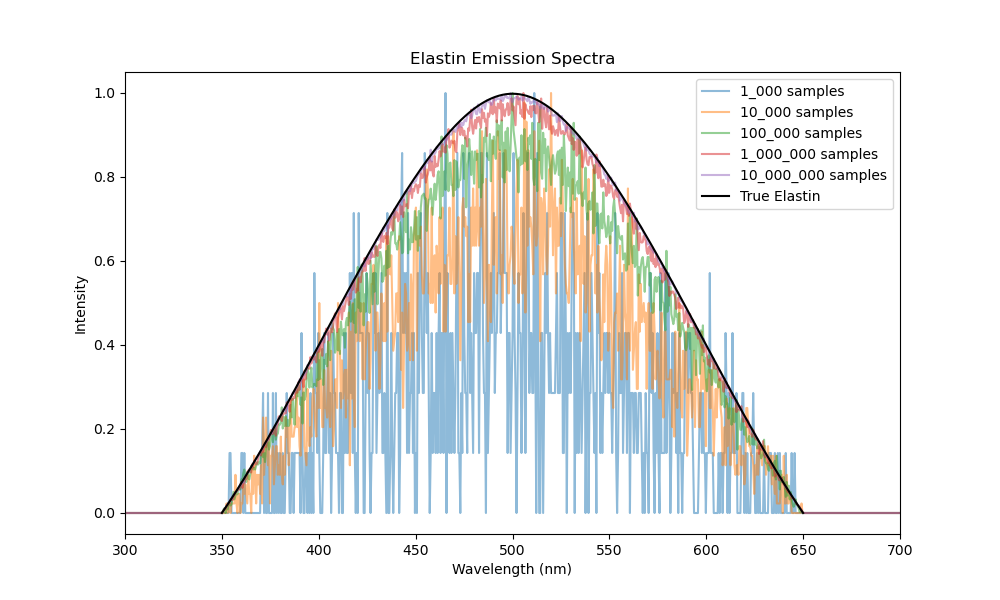

In [12]:
%matplotlib widget
number_of_samples = [1000 * (10**i) for i in range(0, 5)]
# number_of_samples = [1_000 * i for i in range(10, 15)]
number_of_samples

# set palette to rocket
# sns.set_palette("tab10")

plt.figure(figsize=(10, 6))
for i in number_of_samples:
    samples = elastin.sample_emission_spectral(i)
    normalised_samples = samples / np.max(samples)
    print(f"Shape of samples: {samples.shape}")
    print(f"Shape of wavelength_spectra: {wavelength_spectra.shape}")
    sns.lineplot(
        x=wavelength_spectra, y=normalised_samples, label=f"{i:_} samples", alpha=0.5
    )

sns.lineplot(x=elastin_x, y=elastin_y, label="True Elastin", alpha=1, c="black")
plt.xlim(300, 700)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Elastin Emission Spectra")
plt.legend()
plt.show()

In [13]:
# number_of_samples = [1000 * (10**i) for i in range(0, 5)]
# number_of_samples

# #set palette to rocket
# # sns.set_palette("coolwarm")
# # reset palette of sns
# sns.set_palette("tab10")


# for i in number_of_samples:
#     samples = elastin.sample_emission_spectral(i)
#     normalised_samples = samples / np.max(samples)
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(x=wavelength_spectra, y=normalised_samples, label=f"{i:_} samples", alpha=0.7)
#     sns.lineplot(x=elastin_x, y=elastin_y, label="True Elastin", alpha =1)
#     plt.xlabel("Wavelength (nm)")
#     plt.ylabel("Intensity")
#     plt.title("Elastin Emission Spectra")
#     plt.legend()
#     plt.xlim(300, 700)
#     plt.show()

### Sampled spectra of Random Fluorophore

In [14]:
random_fluoro_x = np.linspace(*rd_boounds, 1000)
random_fluoro_y = rd_spline(random_fluoro_x)
random_fluoro_y = random_fluoro_y / np.max(random_fluoro_y)

In [15]:
# number_of_samples = [1000 * (10**i) for i in range(0, 5)]
# number_of_samples

# # set palette to rocket
# sns.set_palette("tab10")

# plt.figure(figsize=(10, 6))
# for i in number_of_samples:
#     samples = random_fluoro.sample_emission_spectral(i)
#     normalised_samples = samples / np.max(samples)
#     sns.lineplot(
#         x=wavelength_spectra, y=normalised_samples, label=f"{i:_} samples", alpha=0.5
#     )

# # sns.lineplot(x=elastin_x, y=elastin_y, label="True Elastin", alpha =1, c='black')
# sns.lineplot(
#     x=random_fluoro_x, y=random_fluoro_y, label="Random Fluoro", alpha=1, c="black"
# )
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Intensity")
# plt.title("Random Fluorophore Emission Spectra")
# plt.legend()
# # plt.xlim(850, 1000)
# plt.show()

## Sample Straight Line Fluoro

Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)
Shape of samples: (1375,)
Shape of wavelength_spectra: (1375,)


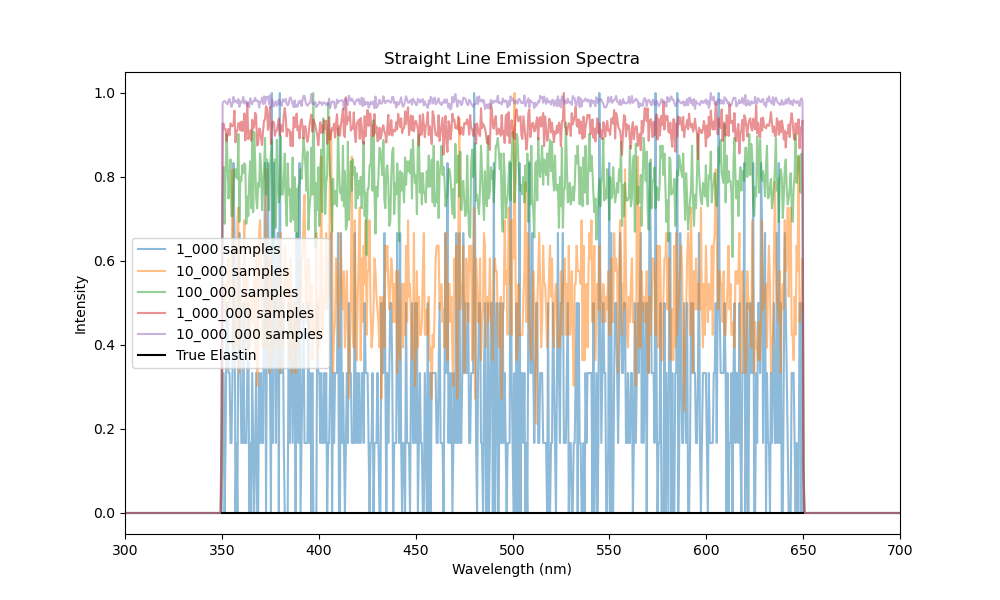

In [15]:
%matplotlib widget
number_of_samples = [1000 * (10**i) for i in range(0, 5)]
# number_of_samples = [1_000 * i for i in range(10, 15)]
number_of_samples

# set palette to rocket
# sns.set_palette("tab10")

plt.figure(figsize=(10, 6))
for i in number_of_samples:
    samples = straight_line_fluoro.sample_emission_spectral(i)
    normalised_samples = samples / np.max(samples)
    print(f"Shape of samples: {samples.shape}")
    print(f"Shape of wavelength_spectra: {wavelength_spectra.shape}")
    sns.lineplot(
        x=wavelength_spectra, y=normalised_samples, label=f"{i:_} samples", alpha=0.5
    )

sns.lineplot(x=straight_line_x, y=straight_line_y, label="True Elastin", alpha=1, c="black")
plt.xlim(300, 700)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Straight Line Emission Spectra")
plt.legend()
plt.show()

# Spectral Jitter
Checking the spectral jitter as we vary the irf's mu inline with fixed and increasing mu

In [13]:
%load_ext line_profiler

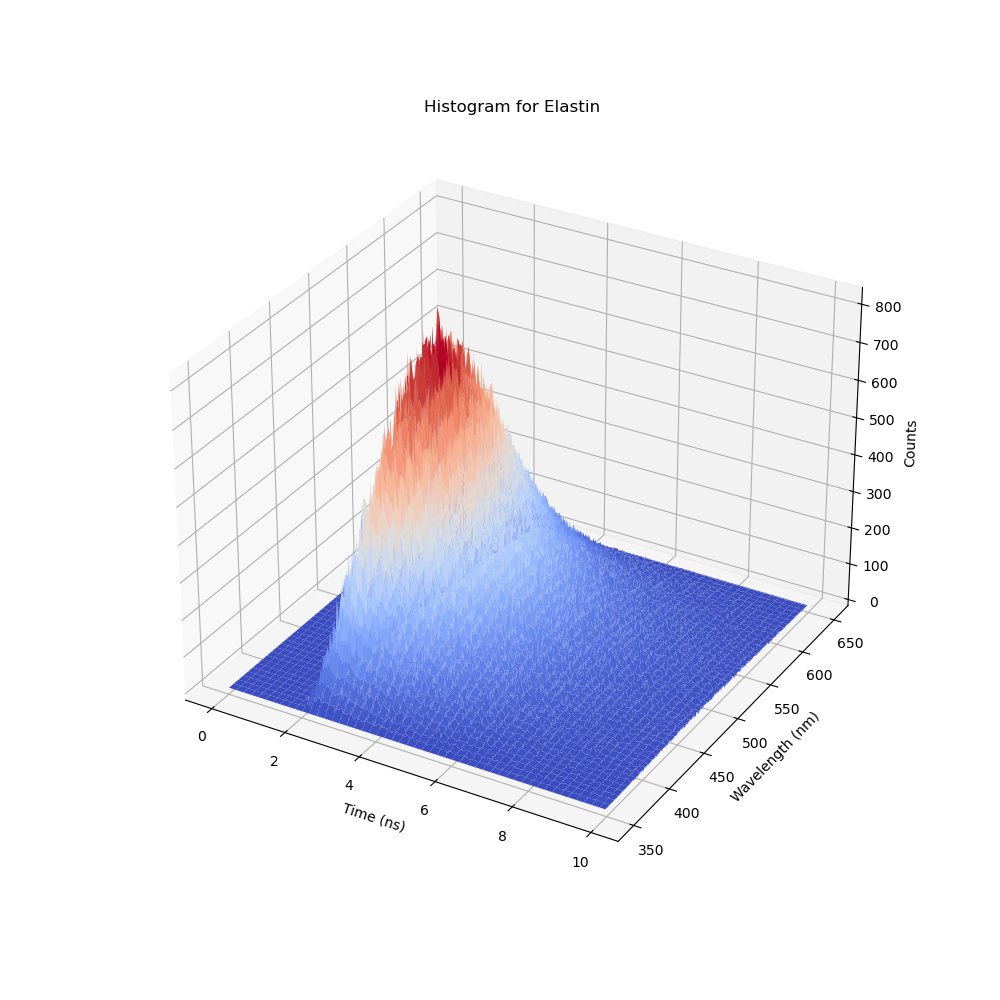

Timer unit: 1e-09 s

Total time: 2.94905 s
File: /home/markus/code/fluoro-data-gen/checks/../src/Tissue_Fluorophore.py
Function: generate_data at line 268

Line #      Hits         Time  Per Hit   % Time  Line Contents
   268                                               def generate_data(
   269                                                   self,
   270                                                   total_samples: int,
   271                                                   use_spectral_sensitivity: bool = True,
   272                                                   use_bias: bool = True,
   273                                                   add_irf: bool = True,
   274                                                   verbose: bool = False,
   275                                               ) -> np.ndarray:
   276                                                   """
   277                                                   This function is used to generate the data for

In [14]:
%matplotlib widget
elastin.average_lifetime = 1.7
# elastin_data = elastin.generate_data(50_000_000, use_bias=False, use_spectral_sensitivity=False)
%lprun -f elastin.generate_data elastin.generate_data(10_000_000, use_bias=False, use_spectral_sensitivity=False)
elastin_data = elastin.data

elastin.plot_data(view_entire_spectral_range=False, time_range=(0, 10))

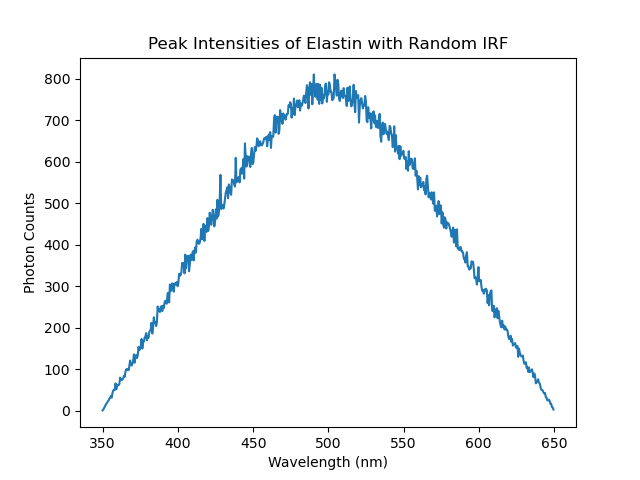

In [18]:
wavelength_spectra, peak_intensities = get_peak_intensity_per_channel(
    elastin_data, elastin.bias.get_intensity_matrix_indicies(), True
)
peak_intensities = np.array(peak_intensities)
# peak_intensities = peak_intensities / np.max(peak_intensities)

plt.figure()
plt.plot(wavelength_spectra, peak_intensities)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Photon Counts")
plt.title("Peak Intensities of Elastin with Random IRF")
plt.show()

In [19]:
print(f"Elastin Incidies: {elastin.bias.get_intensity_matrix_indicies()}")
elastin_incides = elastin.bias.get_intensity_matrix_indicies()
time_axis = np.linspace(0, 60, 1200)

Elastin Incidies: (98, 688)


/home/markus/code/404-cancer-not-found/simulations/fluorophores/Tissue_Fluorophore.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  irf_wavelengths = torch.tensor(irf_emission_samples, device=device)


Shape of irf delay: torch.Size([6875000])
Shape of inverse cdf lifetime samples: torch.Size([6875000])
Missing indexes: set()
Wavelength channel indicies: tensor([   0,    0,    0,  ..., 1374, 1374, 1374])
Unique wavelength indcies 1375


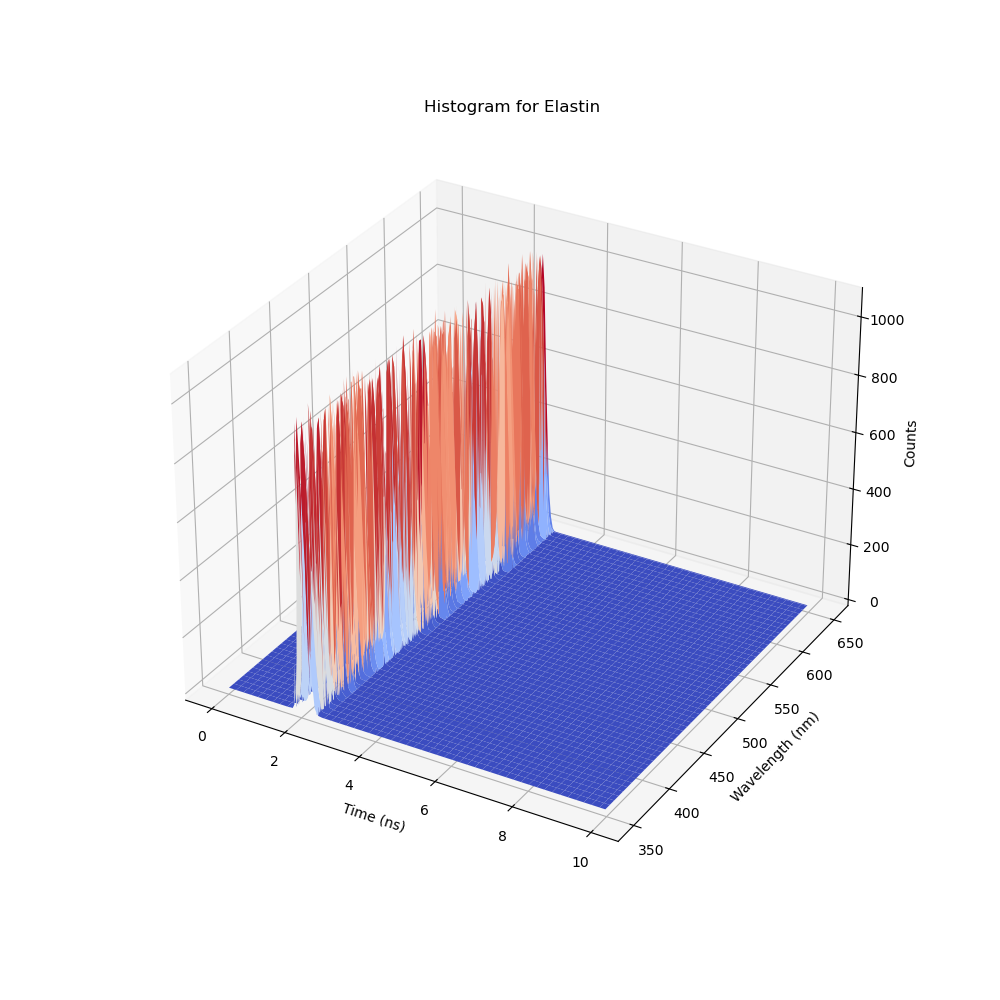

In [20]:
irf_wave = elastin.extract_irf_wave()
elastin.plot_data(irf_wave, view_entire_spectral_range=False, time_range=(0, 10))

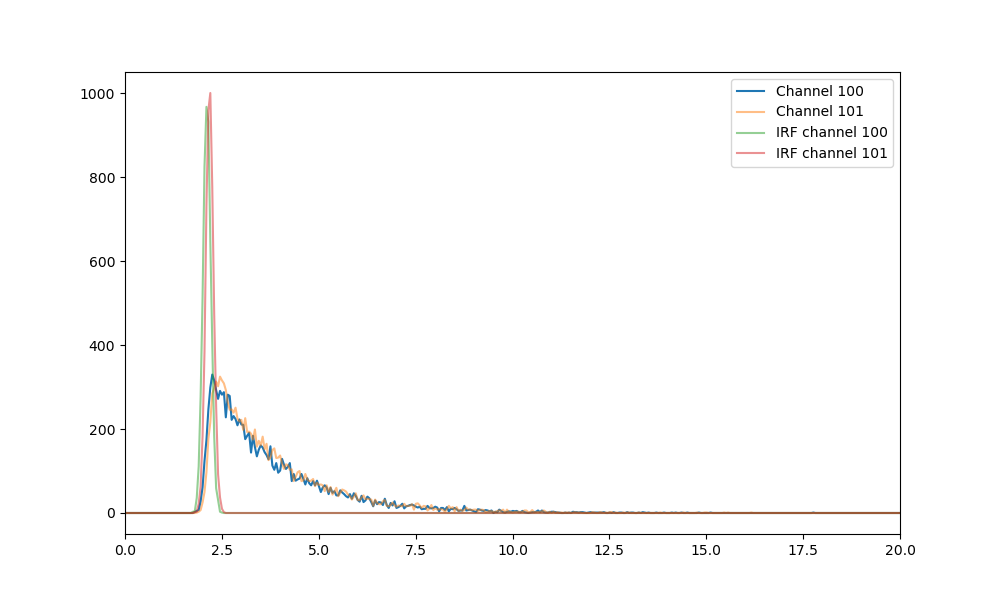

In [21]:
plt.figure(figsize=(10, 6))
# plt.plot(elastin_data[elastin_incides[0] + 100])
# plt.plot(elastin_data[elastin_incides[0] + 101])
sns.lineplot(
    x=time_axis, y=elastin_data[elastin_incides[0] + 100], label="Channel 100", alpha=1
)
sns.lineplot(
    x=time_axis,
    y=elastin_data[elastin_incides[0] + 101],
    label="Channel 101",
    alpha=0.5,
)
sns.lineplot(
    x=time_axis,
    y=irf_wave[elastin_incides[0] + 100],
    label="IRF channel 100",
    alpha=0.5,
)
sns.lineplot(
    x=time_axis,
    y=irf_wave[elastin_incides[0] + 101],
    label="IRF channel 101",
    alpha=0.5,
)
plt.xlim(0, 20)
plt.show()

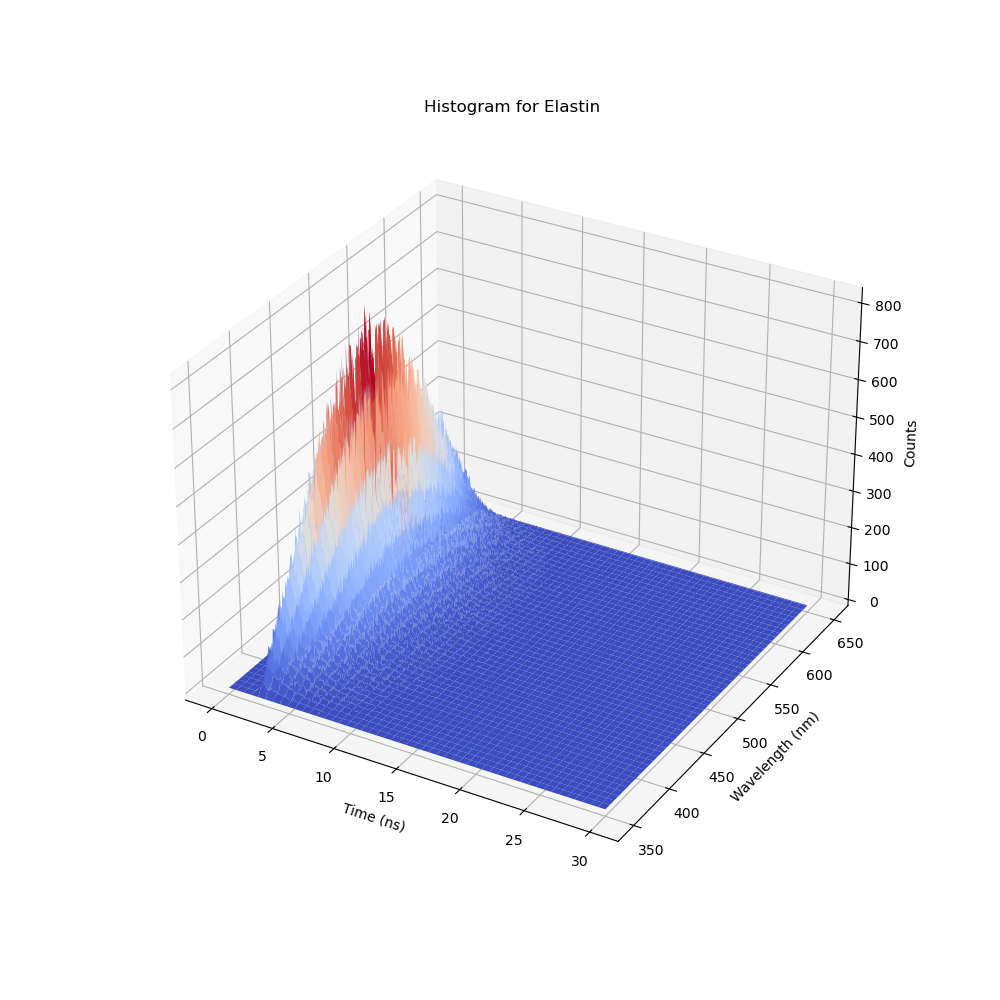

In [22]:
elastin_data_varying_irf = elastin.generate_data(
    10_000_000, use_bias=False, use_spectral_sensitivity=False
)
elastin.plot_data()

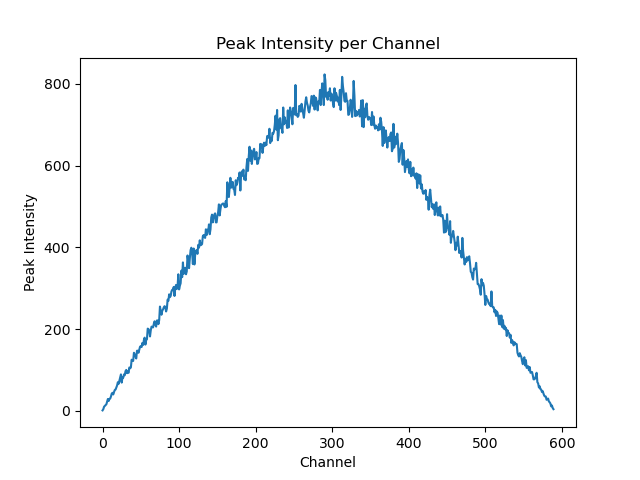

In [23]:
varying_irf_peak_intensity = get_peak_intensity_per_channel(
    elastin_data_varying_irf, elastin.bias.get_intensity_matrix_indicies()
)

plt.figure()
plt.plot(varying_irf_peak_intensity)
plt.xlabel("Channel")
plt.ylabel("Peak Intensity")
plt.title("Peak Intensity per Channel")
plt.show()

# Convergence of Expontential

In [24]:
time_axis = np.linspace(0, 60, 1200)

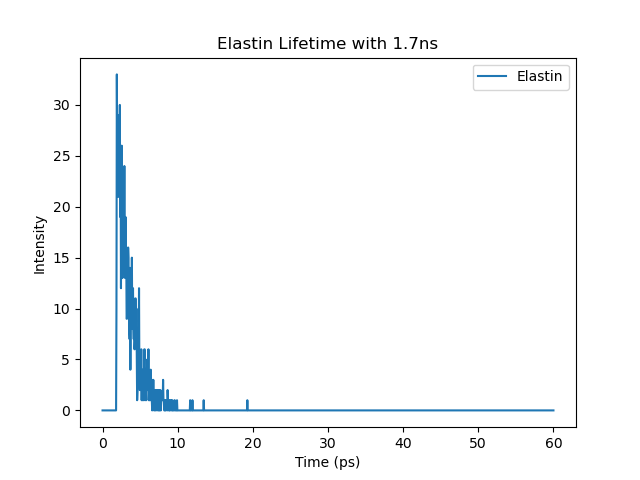

In [25]:
x = elastin.sample_life(1_000, 1.7, True)

plt.figure()
sns.lineplot(x=time_axis, y=x, label="Elastin")
plt.xlabel("Time (ps)")
plt.ylabel("Intensity")
plt.title("Elastin Lifetime with 1.7ns")
plt.show()

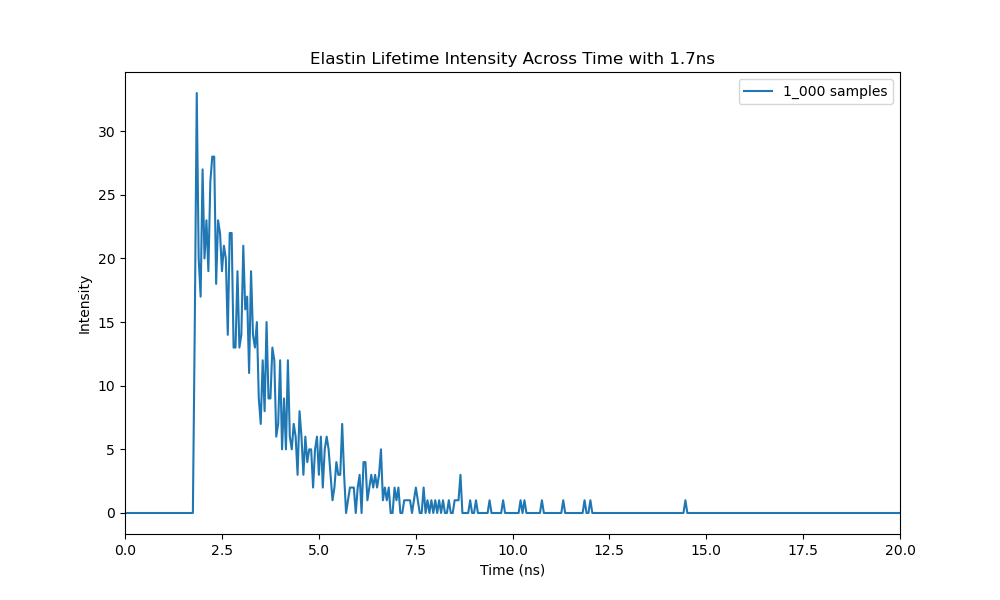

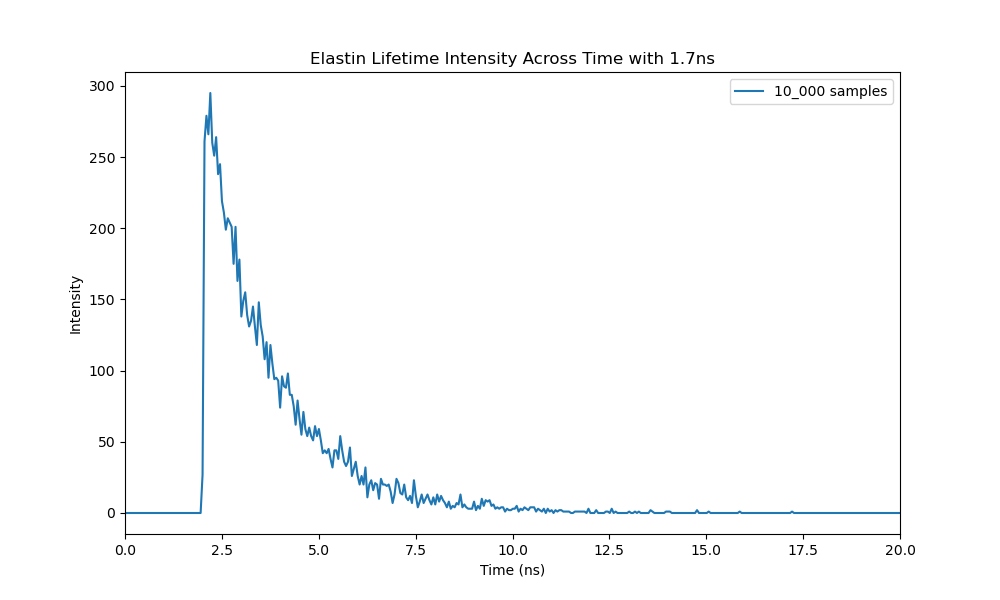

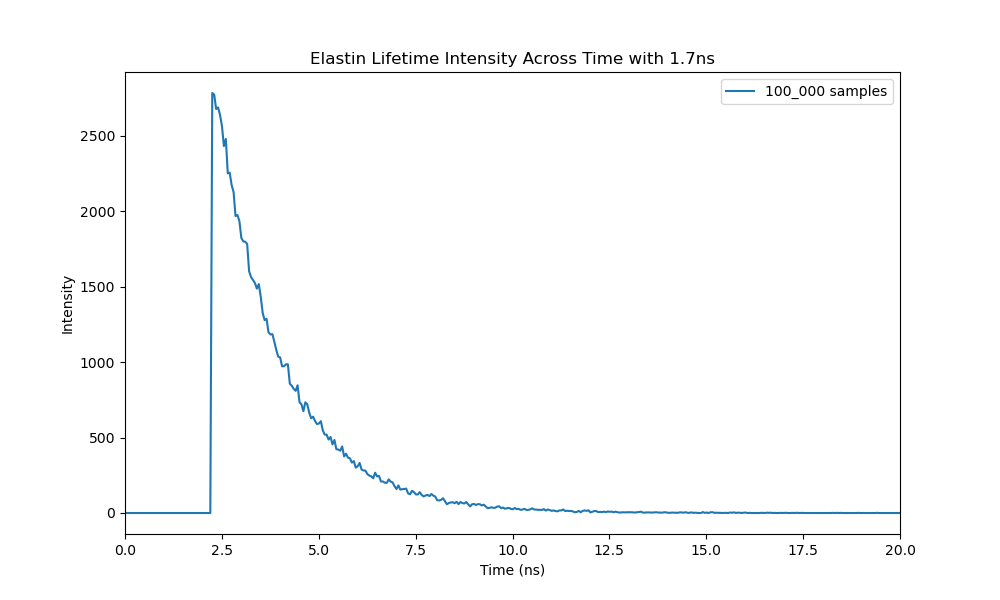

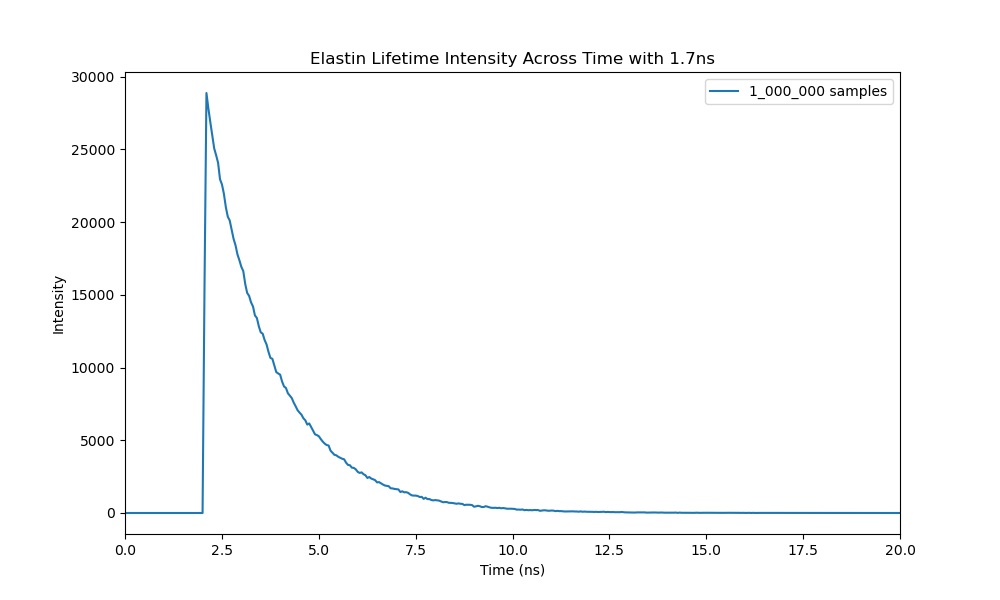

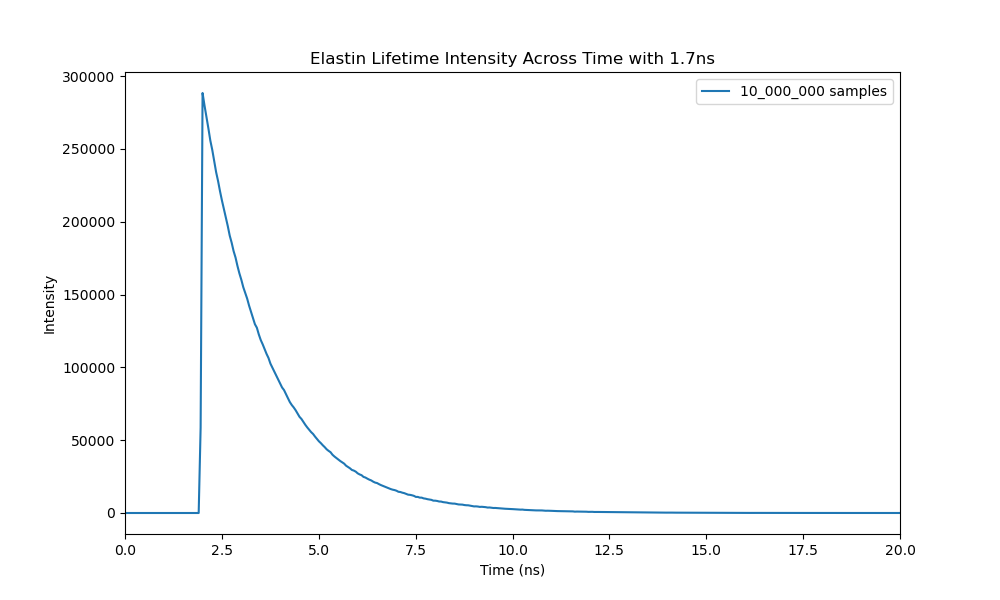

In [26]:
%matplotlib widget
number_of_samples = [1000 * (10**i) for i in range(0, 5)]
# number_of_samples.append(500_000)

#set palette to rocket
sns.set_palette("tab10")


for i in number_of_samples:
    samples = elastin.sample_life(i, 1.7, True)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=time_axis, y=samples, label=f"{i:_} samples", alpha=1)

# sns.lineplot(x=elastin_x, y=elastin_y, label="True Elastin", alpha =1, c='black')
# sns.lineplot(x=random_fluoro_x, y=random_fluoro_y, label="Random Fluoro", alpha =1, c='black')
    plt.xlabel("Time (ns)")
    plt.ylabel("Intensity")
    plt.title("Elastin Lifetime Intensity Across Time with 1.7ns")
    plt.legend()
    plt.xlim(0, 20)
# set log scale
# plt.yscale("log")
# plt.xlim(725, 925)
    plt.show()  

# Convergence to Expontential with Bias
We should see the singal to noise ratio decrease as the photons increase

In [27]:
# set sns to whitegrid
sns.set_style("whitegrid")

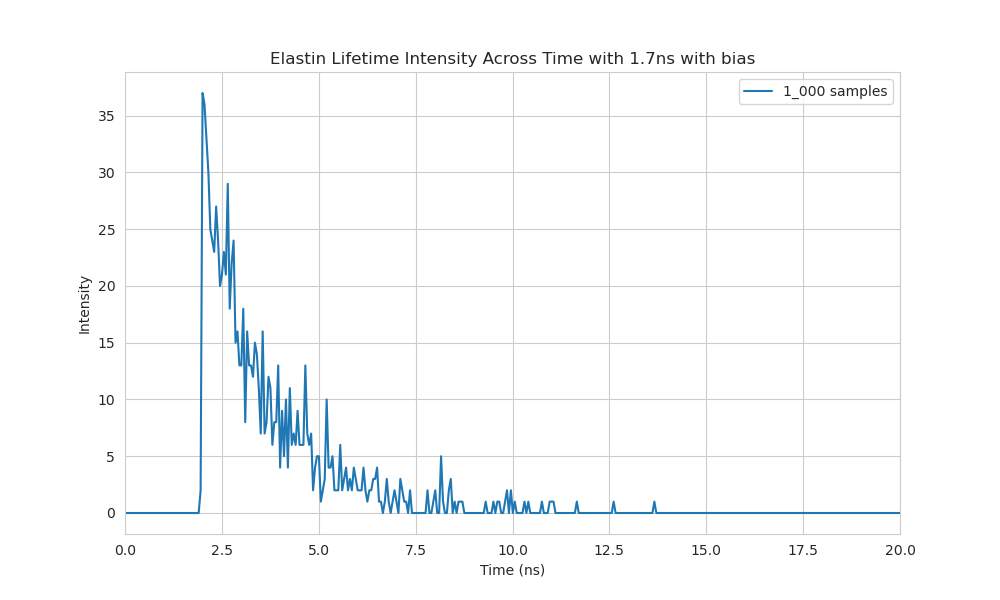

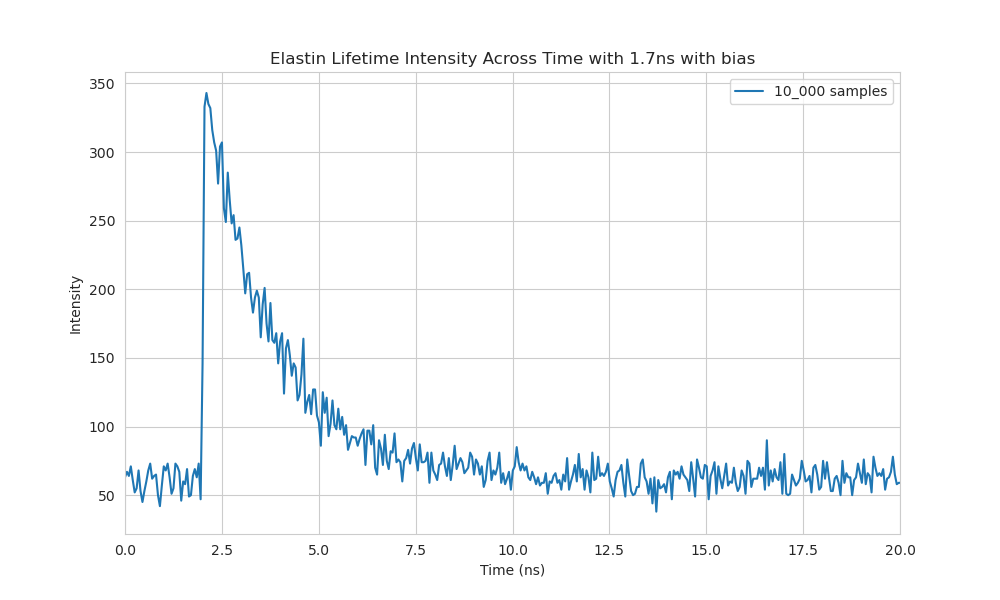

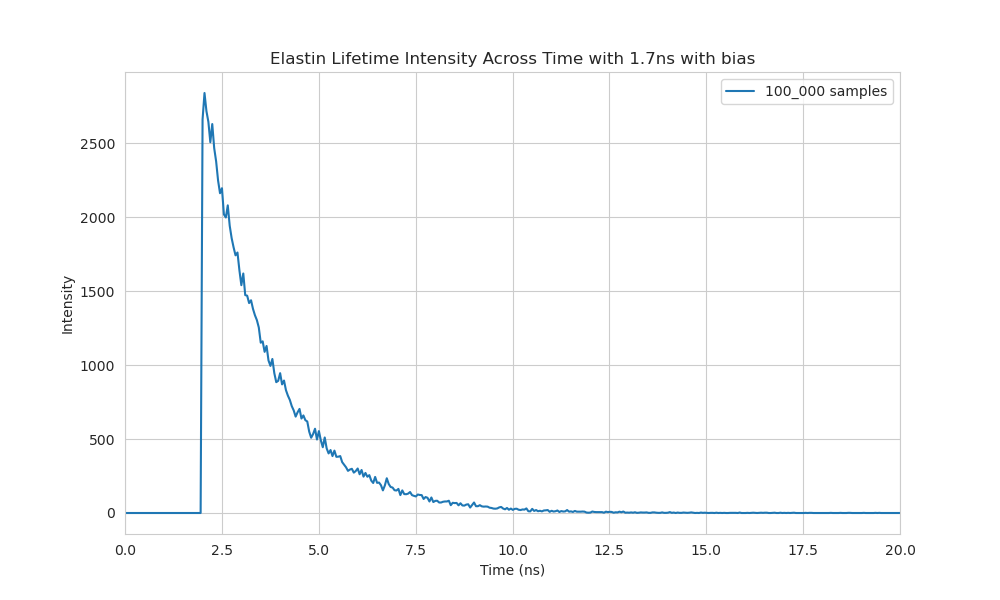

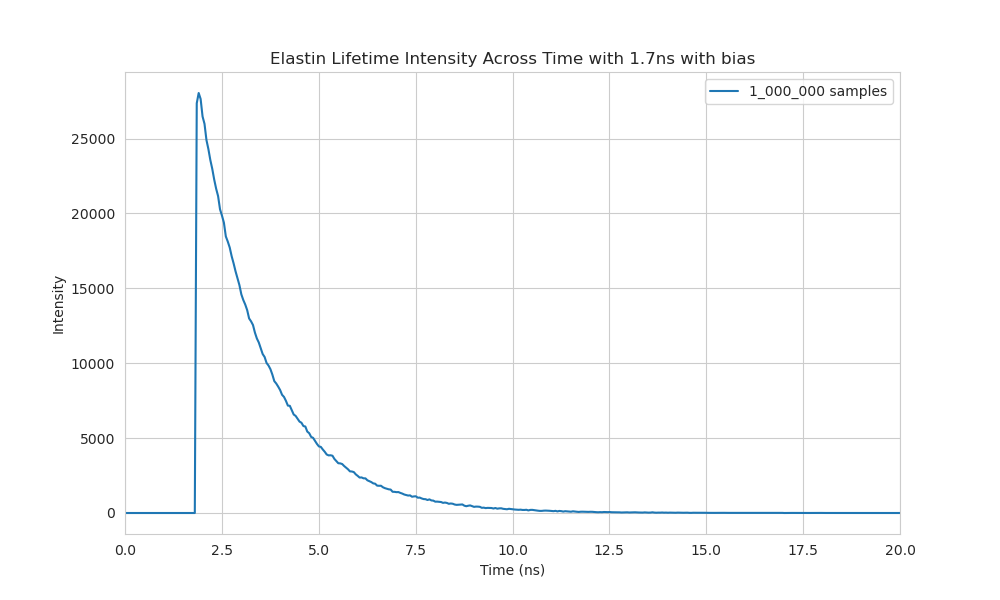

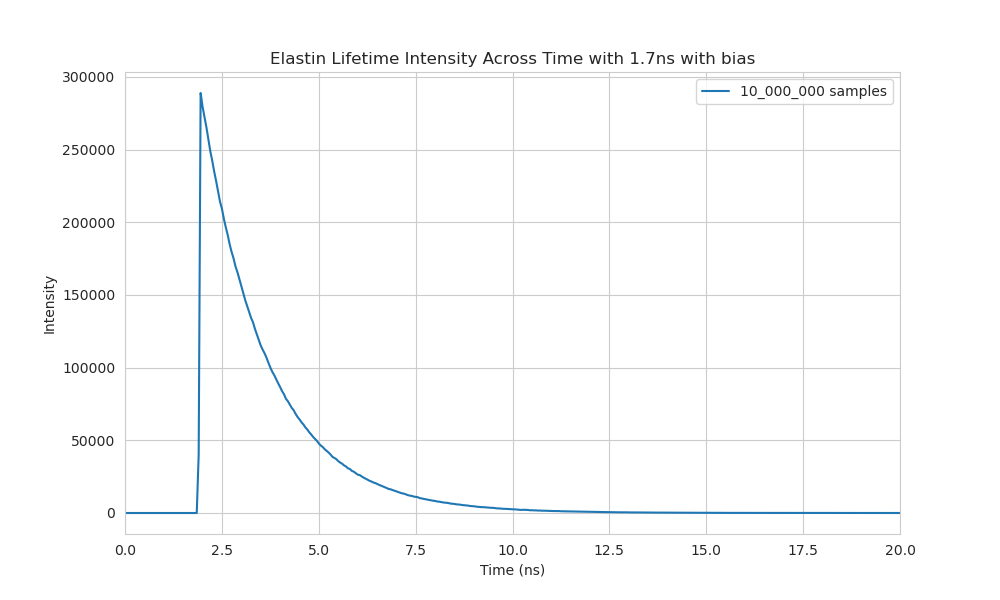

In [28]:
%matplotlib widget
number_of_samples = [1000 * (10**i) for i in range(0, 5)]
# number_of_samples.append(500_000)

#set palette to rocket
sns.set_palette("tab10")


for i in number_of_samples:
    samples = elastin.sample_life(i, 1.7, with_irf=True, with_bias=True)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=time_axis, y=samples, label=f"{i:_} samples", alpha=1)

# sns.lineplot(x=elastin_x, y=elastin_y, label="True Elastin", alpha =1, c='black')
# sns.lineplot(x=random_fluoro_x, y=random_fluoro_y, label="Random Fluoro", alpha =1, c='black')
    plt.xlabel("Time (ns)")
    plt.ylabel("Intensity")
    plt.title("Elastin Lifetime Intensity Across Time with 1.7ns with bias")
    plt.legend()
    plt.xlim(0, 20)
# set log scale
# plt.yscale("log")
# plt.xlim(725, 925)
    plt.show()  

# Convergences to exponential shape with longer lifetimes
We will compare 4 lifetimes :
- 0.5 ns
- 1.5 ns
- 3.5 ns
- 5 ns


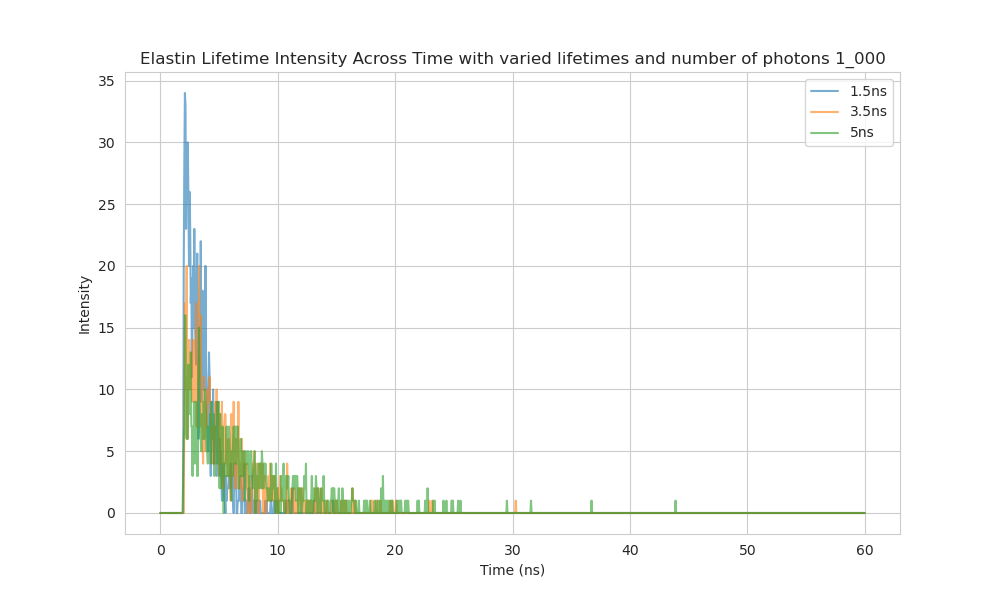

/tmp/ipykernel_66363/448905785.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


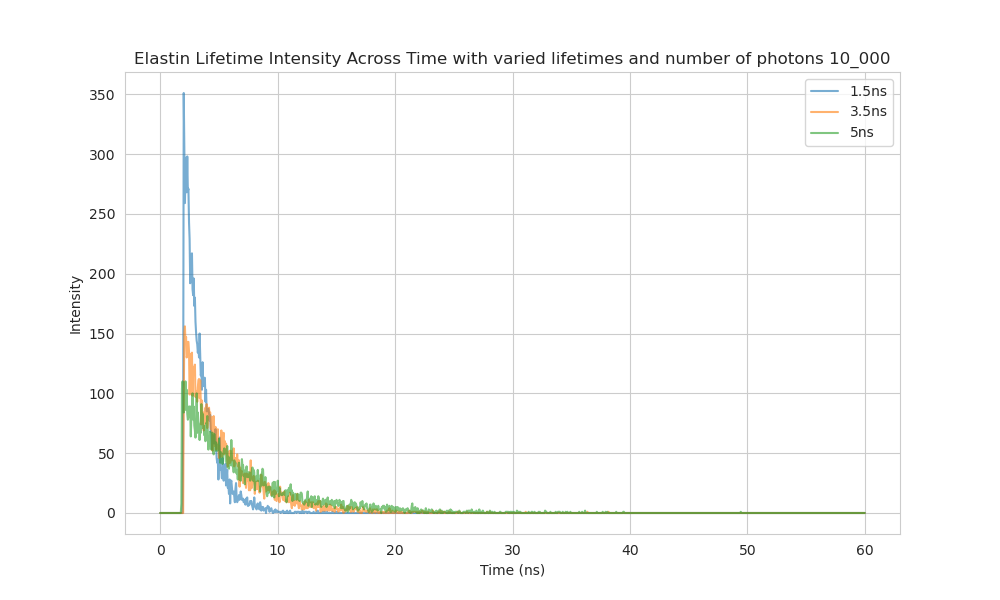

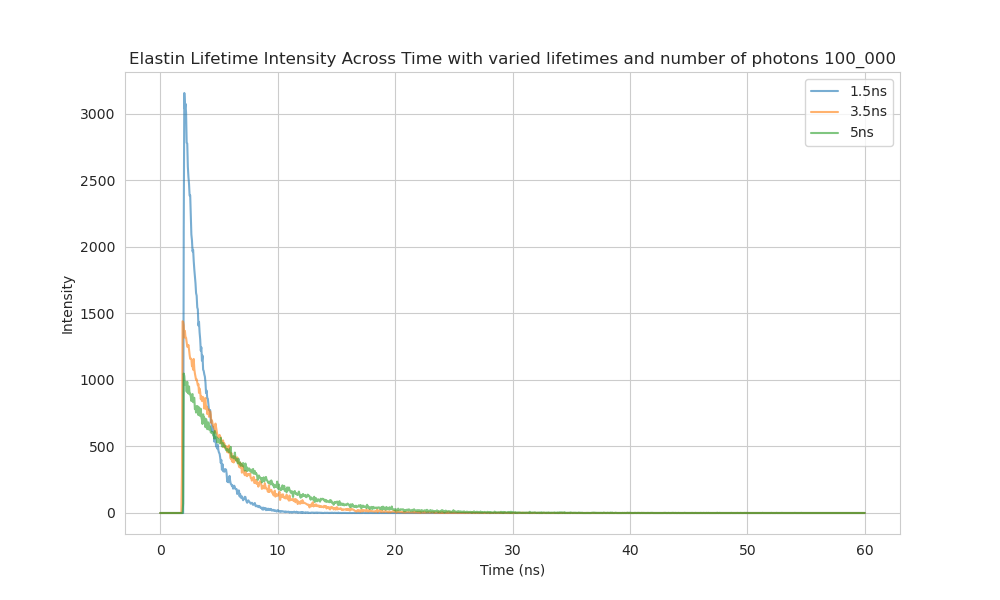

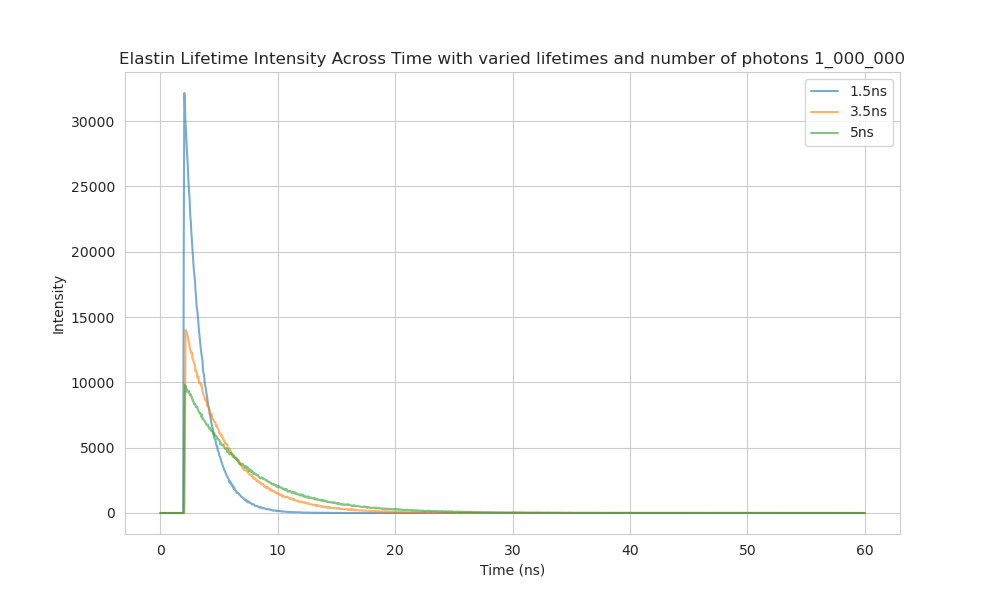

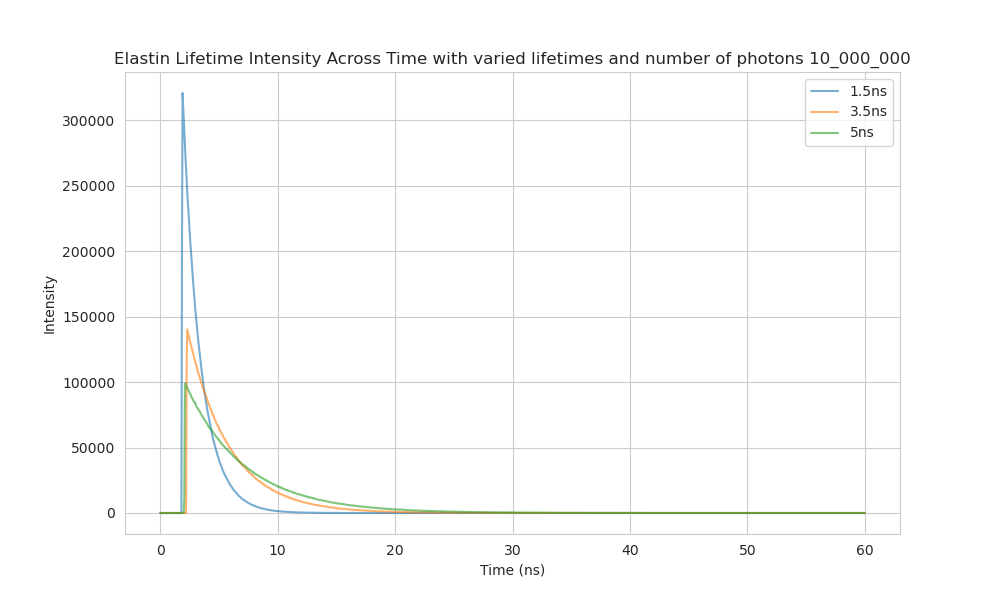

In [29]:
%matplotlib widget
number_of_samples = [1000 * (10**i) for i in range(0, 5)]
lifetimes = [1.5, 3.5, 5]
# number_of_samples.append(500_000)

#set palette to rocket
sns.set_palette("tab10")


for i in number_of_samples:
    plt.figure(figsize=(10, 6))
    for tau in lifetimes:
        samples = elastin.sample_life(i, tau, with_irf=True, with_bias=False)

        sns.lineplot(x=time_axis, y=samples, label=f"{tau}ns", alpha=0.6)
    # sns.lineplot(x=time_axis, y=samples, label=f"{i:_} samples", alpha=1)

# sns.lineplot(x=elastin_x, y=elastin_y, label="True Elastin", alpha =1, c='black')
# sns.lineplot(x=random_fluoro_x, y=random_fluoro_y, label="Random Fluoro", alpha =1, c='black')
    plt.xlabel("Time (ns)")
    plt.ylabel("Intensity")
    plt.title(f"Elastin Lifetime Intensity Across Time with varied lifetimes and number of photons {i:_}")
    plt.legend()
    # plt.xlim(0, 30)
# set log scale
# plt.yscale("log")
# plt.xlim(725, 925)
    plt.show()  